In [1]:
%load_ext nvcc4jupyter

from nvcc4jupyter import set_defaults
set_defaults(compiler_args='-arch=sm_100a -Xptxas=-v')

Source files will be saved in "/tmp/tmp_j2vj48f".


What we will do, is try to get to the start and end of running 1 tensor core matmul on the new ISA. 

# Tensor Memory: 
on basically any card of blackwell, we have 128 lanes (rows) and 512 columns of TMEM. 
the first 16 bits (bits 0 to 15) inclusive, give you the column idx. 
the next 16 bits (bits 16 to 31) inclusive, give yuou the lane index. 
each cell holds 32-bit types. 



In [3]:
def get_TMEM_addr(lane, col): 
  assert col < 512 
  assert lane < 128 
  return (lane << 16) | col 

def print_bin(n, width): 
  print(f"{n:0{width}b}")

In [6]:
lane_id = 12 
col_id = 16
print_bin(lane_id, 16)
print_bin(col_id, 16)
tmem_addr = get_TMEM_addr(lane_id, col_id) 
print_bin(tmem_addr, 32)

print(2**16 - 1)

0000000000001100
0000000000010000
00000000000011000000000000010000
65535


In [18]:
print_bin((2<<15)-1, 16)
print((2 << 15) - 1)

1111111111111111
65535


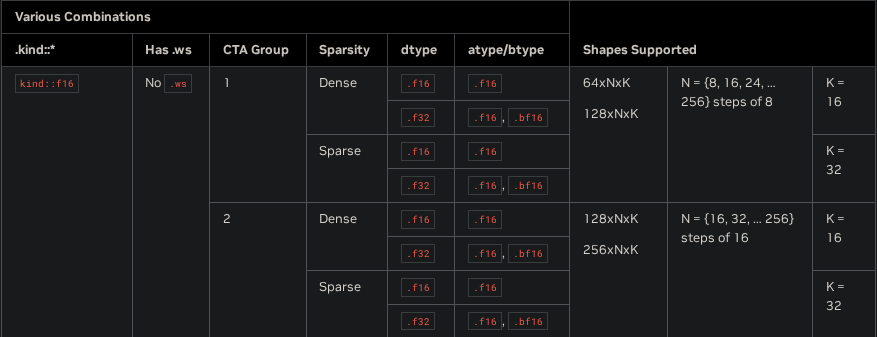



In the above table, we will DENSE matmul, use 2 CTA groups, have dtype = f32, atype/btype is bf16 (1 sign bit, 8 exponent bits, 7 mantissa bits)
we will use M = 256, N = 256, K = 16, and NO.ws 
In light of the fact that A:(256,16) and B:(16,256) we will think 
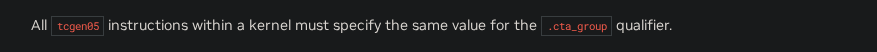

okay, first thene we are fixed to two cta cluster, lets fucking do the first thing which is to get my 
shit from SMEM to TMEM for that we need the tcgen5.cp instructions. 

tcgen05.cp.cta_group.shape{.multicast}{.dst_fmt.src_fmt} [taddr], s-desc;

.cta_group = { .cta_group::1, .cta_group::2 }
.src_fmt   = { .b6x16_p32 , .b4x16_p64 }
.dst_fmt   = { .b8x16 }
.shape     = { .128x256b, .4x256b, .128x128b, .64x128b**, .32x128b*** }
.multicast = { .warpx2::02_13** , .warpx2::01_23**, .warpx4*** }```

In the anbove leice of code, we know we want cta_group::2, scr_fmt, dst_fmt are optional decompress whatver, we don't care about that for our types,

###### the smem-descritor: 

we can ignore.dst_fmt.scr_fmt hence now we are left with trying to upack and understand: 

-smem-descriptor (s-desc) 
-shape and its co-responding multicast, if needed, 
and that should be it. 

So lets start with smem-descriptor: 
